<a href="https://colab.research.google.com/github/timothewt/Bird_Pictures_Recognition/blob/main/CNN_Bird_Photos_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading birds pictures

In [1]:
import urllib.request
import os
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import math

Setting the environment in the correct directory and getting the API's secret key

In [2]:
if os.getcwd() == "/content":
  os.chdir("drive/MyDrive/GAN_Birds")
with open("api_secret_key.txt") as f:
  api_secret_key = f.read()

Installing the Flickr's API to retrieve photos

In [3]:
!pip install -q flickrapi
from flickrapi import FlickrAPI
flickr = FlickrAPI("dee4b1d3673f1a96f5261e091a56f42a", api_secret_key, format='parsed-json')

Retrieving the photos as arrays

In [4]:
def get_pictures_as_arrays(text: str, number: int) -> np.array:
  pages_num = min(math.floor(number // 500) + 1, 8)

  pages = [
      flickr.photos.search(text=text, per_page=min(500, number), page=page_num, extras="url_q", sort='relevance')['photos'] for page_num in range(1, pages_num + 1)
    ]
    
  photos = []

  for i, page in enumerate(pages):
    # print(f"Page num.{i + 1}")
    photos.extend([np.array(Image.open(BytesIO(requests.get(photo['url_q']).content))) for photo in page["photo"]])

  # print("Done")

  return photos[:number]

Method used to display an image represented in an array

In [5]:
def show_images(images: np.array) -> None:
  fig = plt.figure(figsize=(len(images) * 3.5, 3.5))
  for i, image in enumerate(images):
    fig.add_subplot(1, len(images), i + 1)
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')
  plt.show()

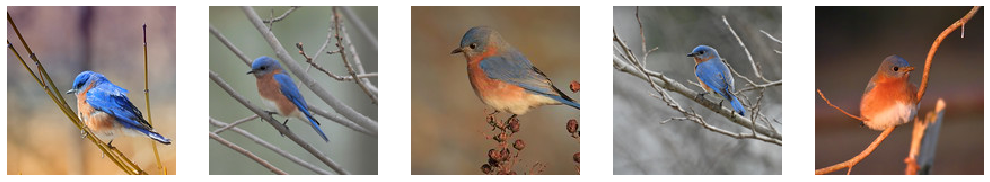

In [6]:
show_images(get_pictures_as_arrays("Eastern Bluebird", 5))

Downloading the bird images dataset and random images dataset

In [7]:
classes = ["Not bird", "Bird"]

if (os.path.isfile("dataset_birds.npy")):
  dataset_birds = np.array([(image, 1) for image in np.load("dataset_birds.npy", allow_pickle=True)], dtype="object")
else:
  dataset_birds = get_pictures_as_arrays("Eastern Bluebird", 4_000)
  dataset_birds = np.array([(image, 1) for image in dataset_birds if len(image.shape) == 3 and image.shape[0] == 150], dtype="object")
  np.save("dataset_birds", dataset_birds)

if (os.path.isfile("dataset_rand.npy")):
  dataset_rand = np.array([(image, 0) for image in np.load("dataset_rand.npy", allow_pickle=True)], dtype="object")
else:
  dataset_rand = get_pictures_as_arrays("Random", 4_000)
  dataset_rand = np.array([(image, 0) for image in dataset_rand if len(image.shape) == 3 and image.shape[0] == 150], dtype="object")
  np.save("dataset_rand", dataset_rand)

dataset = np.concatenate((dataset_birds, dataset_rand))
np.random.shuffle(dataset)

Random photos from the dataset

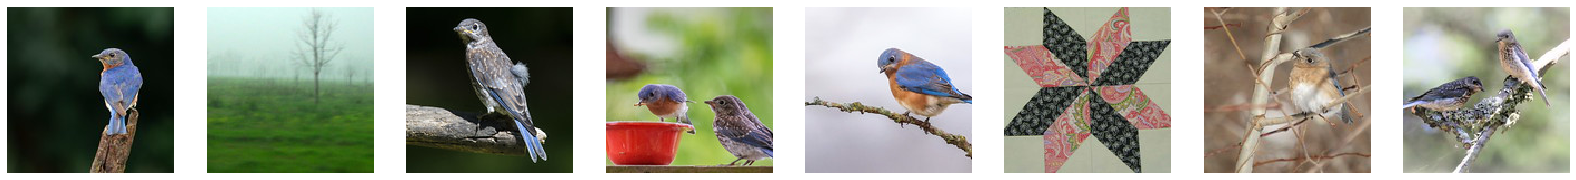

In [8]:
show_images([dataset[np.random.choice(dataset.shape[0], 1, replace=False), :][0][0][0] for i in range(8)])

Once the dataset done, we can now build the CNN to classify the images as Bird or Not bird

## Building the CNN model

Importing PyTorch modules

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

We first normalize and transform the data into tensors.

In [16]:
dataset_normalized = [
    (np.array([(img[0] / 255)[:, :, channel_index] for channel_index in range(3)]), label) for img, label in dataset
]

We set the data into small batches.

Each batch has a tensor of images (shape (3, 150, 150)) and a corresponding tensor of labels.

In [17]:
batch_size = 100
dataset_batches = [
    [
        torch.tensor(np.array([img for img, _ in dataset_normalized[batch_num * batch_size : (batch_num + 1) * batch_size]])).float().to(device),
        torch.tensor(np.array([label for _, label in dataset_normalized[batch_num * batch_size : (batch_num + 1) * batch_size]])).to(device)
    ] for batch_num in range(int(len(dataset) / batch_size) + 1)
]

del dataset_normalized # to free up RAM

We can define a simple function that takes an array of images and outputs the label of each image.

In [18]:
def predict_image_label(image: np.array) -> str:
  image_tensor = torch.tensor(np.array([np.array([(image / 255)[:, :, channel_index] for channel_index in range(3)])])).float().to(device)
  predicted_labels = classes[torch.max(model(image_tensor).detach().cpu(), 1)[1]]
  return predicted_labels

Now we need to create the CNN model.
It consists in:
- 2 layers of 2D Convolution -> Batch normalization -> ReLU -> MaxPooling
- 3 fully connected layers.

It ouputs two values, the 0th being the "chance" that the input is not a bird, and the 1st being the "chance" that it is a bird. We take the max value between the two to determine which one it is.

In [34]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5), # 146x146
      nn.BatchNorm2d(6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2) # 73x73
    )
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),# 69x69
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3) # 23x23
    )
    self.fc1 = nn.Linear(16 * 23 * 23, 1024)
    self.fc2 = nn.Linear(1024, 128)
    self.fc3 = nn.Linear(128, 2)

  def forward(self, rgb_image):
    out1 = self.layer1(rgb_image)
    out2 = self.layer2(out1)
    out2_flat = torch.flatten(out2, 1)
    out3 = self.fc1(out2_flat)
    out4 = self.fc2(out3)
    out5 = self.fc3(out4)
    return out5

model = CNN()
model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Training the model

In [35]:
num_epochs = 1500

loss_hist = np.zeros(num_epochs)
acc_hist = np.zeros(num_epochs)

for t in range(num_epochs):

    images, labels = dataset_batches[t % len(dataset_batches)]

    output = model(images)

    loss = loss_fn(output, labels)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    accuracy = (dataset_batches[t % len(dataset_batches)][1] == torch.max(output, 1)[1]).sum() / len(dataset_batches[t % len(dataset_batches)][1])

    if (t + 1) % (int(num_epochs / 10)) == 0 and t !=0:
        print(f"Epoch {t + 1} - CEE: {loss.item()}, Acc: {accuracy}")
    loss_hist[t] = loss.item()
    acc_hist[t] = accuracy

print("--- Training finished ---")

Epoch 150 - CEE: 0.34121173620224, Acc: 0.8299999833106995
Epoch 300 - CEE: 0.20762868225574493, Acc: 0.8999999761581421
Epoch 450 - CEE: 0.28728821873664856, Acc: 0.8899999856948853
Epoch 600 - CEE: 0.16788548231124878, Acc: 0.9300000071525574
Epoch 750 - CEE: 0.16249419748783112, Acc: 0.9300000071525574
Epoch 900 - CEE: 0.11100646108388901, Acc: 0.9300000071525574
Epoch 1050 - CEE: 0.08018624037504196, Acc: 0.9799999594688416
Epoch 1200 - CEE: 0.1163080483675003, Acc: 0.9718309640884399
Epoch 1350 - CEE: 0.0845499113202095, Acc: 0.9599999785423279
Epoch 1500 - CEE: 0.04614712670445442, Acc: 1.0
--- Training finished ---


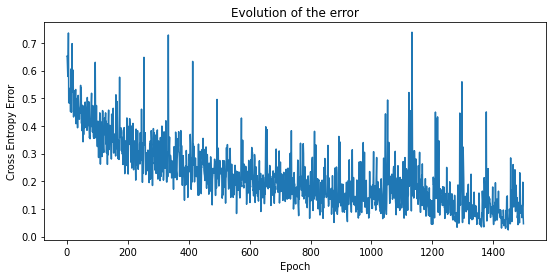

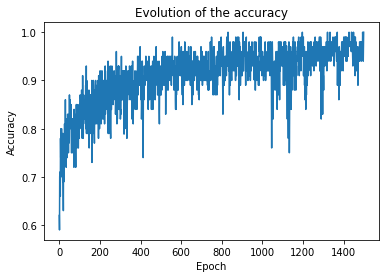

In [36]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot()
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Error')
plt.title("Evolution of the error")
plt.plot(loss_hist)
plt.show()
ax = fig.add_subplot()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Evolution of the accuracy")
plt.plot(acc_hist)
plt.show()

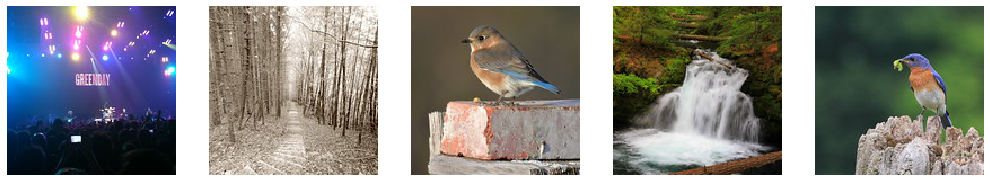

Predicted labels: Not bird, Not bird, Bird, Not bird, Bird


In [38]:
images = [
    get_pictures_as_arrays("Random",9)[8],
    get_pictures_as_arrays("Forest", 5)[4],
    get_pictures_as_arrays("Eastern Bluebird", 10)[9],
    get_pictures_as_arrays("Waterfall", 3)[2],
    get_pictures_as_arrays("Eastern Bluebird rock", 6)[5],
]

# images = [data[0][0] for data in dataset[310:316]]

predictions = [predict_image_label(image) for image in images]

show_images(images)
print(f"Predicted labels: {', '.join(predictions)}")